#### Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()


# The goal of this notebook is to help you understand the basics of training a machine learning model. For more information, read the accompanying blogpost: 

In this notebook we will:
- Introduce the problem we'll solve with ML.
- define a forward pass through our model
- define a cost function
- create a backward pass to update the model



## Introducing the problem

You are working for an insurance company who wants to predict the total payment for all the claims in thousands of Swedish Kronor for geographical zones in Sweden. We will work with only one feature, the number of claims received, and will use that information to train our model and make predictions.

In [2]:
# import packages we need :)
from typing import Tuple, List
import requests
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
# You can skip understanding the following code. It's only here to get some data to work with.
def build_auto_insurance_dataset() -> Tuple[List[float], List[float]]:
    url='https://www.math.muni.cz/~kolacek/docs/frvs/M7222/data/AutoInsurSweden.txt'
    raw_dataset = requests.get(url)
    features, labels = [], []
    index_at_which_features_and_labels_start = 11

    raw_data = raw_dataset.text.split("\n")[index_at_which_features_and_labels_start:-1]
    for feature_and_label in raw_data:
        feature_and_label = feature_and_label.split("\t")
        features.append([float(feature_and_label[0].replace(",", "."))])
        labels.append(float(feature_and_label[1].replace(",", ".")))
    return jnp.array(features), jnp.array(labels).reshape(-1, 1)


# some plotting utils to plot our beautiful graphs

def plot_results(features: List[float], labels: List[float], predictions: List[float]):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(features, labels, 'bo', label='Real values')
    ax.plot(features, predictions, 'ro', label='Predicted values')
    ax.plot(features.reshape(-1), predictions.reshape(-1), label='Real values')
    ax.legend(["Actual", "Predicted"])
    ax.set_ylabel("Claims in thousands of Swedish kronor")
    ax.set_xlabel("Number of claims")
    return fig, ax


## The dataset
In this section we'll explore the dataset.

In [4]:
# features is equal to the total number of claims for a given year
# labels is the total payment for all claims in thousands of Swedish kronor
features, labels = build_auto_insurance_dataset()


In [5]:
# features is a MxN matrix, where M is the number of examples and N is the number of features
# In our case, N is 1, because we have only one feature
# M is the number of examples, which in our case is 63
# As a result our output is a 63x1 matrix
print(f"Our features has shape: {features.shape}")

# whereas our labels is a Mx1 matrix, where M is the number of examples
print(f"Our labels has shape: {labels.shape}")

Our features has shape: (63, 1)
Our labels has shape: (63, 1)


## Forward pass

We'll be building a very simple network (just a linear regression, yay). The model is defined as f = w * x + b, where y is the value we want to predict, w and b are the parameters we'll optimize and x is the input feature. As it is important to familiarize yourself with 


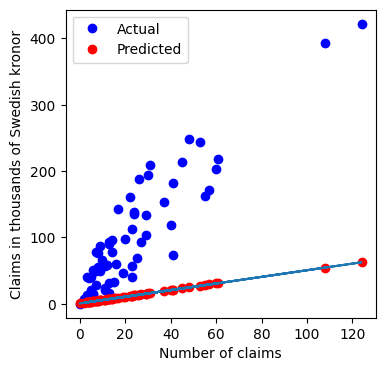

In [6]:
# Introduction to linear regression: f = w * x + b also know as the forward pass.
def forward_pass(feature: jnp.ndarray, weight: jnp.ndarray, bias: jnp.ndarray) -> jnp.ndarray:
    return weight * feature + bias




# We know our model is a Linear Regression model, meaning we have F_w_b(x) = w * x + b where w, b are the model parameters and are a scalar value.
# and x is the model input, which is also a scalar value.
weight = jnp.array([0.5])
bias = jnp.array([0.5]) 
predictions = jnp.array([])
for feature in features:
    prediction = forward_pass(feature=feature, weight=weight, bias=bias)
    predictions = jnp.append(predictions, prediction)


# Lets plot the results
_ = plot_results(features, labels, predictions)

That doesn't look too good... But "doesn't look good" is still a bit vague, don't you think?! Let's try to make it a bit more unambiguous and for that, we need a cost function. 
A cost function is a summation over the loss function for all examples. Arrgh why does that sound so complicated. Can't you be a bit more explicit? Sure :)

Lets first define the loss function: 
$$
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2
$$

The loss function determines how far "off" you are from the true value. The larger the loss is the further away you are from your target.
Now the $y^{true}_i$ is historical data that has already been collected (in our case the claims in thousands of Swedish Kronor)
Our prediction is what we need to compute, which we did during the forward pass. so, we can substitute that in our little formula below.


$$
\begin{align}
forward pass = y^{pred}_i \\
y^{pred}_i = f_{w,b}(x_i)  \\
f_{w,b}(x_i) = w * x_i + b \\
\end{align}
$$
$$
\begin{align}
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2 \\
L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2} * (w * x_i + b - y^{true}_{i})^2 
\end{align}
$$

Alright. So the loss function is defined, but this is only for one feature, label pair (or more simple stated: one training example).
The next part has to do with the cost function often denoted as $J(w, b)$. What does this mean? For a given weight $w$ and bias $b$, calculate the loss function over all training examples.

$$

\frac{1}{m}\sum^{m - 1}_{i=0} * L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2m}\sum^{m - 1}_{i=0}(f_{w,b}(x_{i}) - y_i)^2
$$

notice how we moved the constant out of the equation. In addition that we substitute the quadratic term in the final part of the equation for the $L$.

Pfoeee.... that are quite some lines of mathematical notation. But for now, using the famous words of Andrew Ng, don't worry about it. Lets see some actual code.


In [7]:
# remember that the loss is the difference between the predicted value and the actual value
# and is only for a single example
def calculate_loss(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return 1 / 2 * (predictions - labels) ** 2

# calculate the loss for all examples
def calculate_cost(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean(calculate_loss(predictions, labels))

total_cost = calculate_cost(predictions=predictions, labels=jnp.array(labels))

print(f"The total cost is: {total_cost}")

The total cost is: 7537.8271484375


In [8]:
# Gradient descent
# Taking the derivate of the cost function with respect to the weight and bias.
def compute_gradient(features, weight, bias, labels):
    predictions = forward_pass(features, weight, bias)

    weight_derivative = jnp.mean(((predictions - labels) * features))  
    bias_derivative = jnp.mean((predictions - labels) * 1)
    return weight_derivative, bias_derivative

# update weights and bias using the gradient descent algorithm.
def update_weights(features, weight, bias, labels, learning_rate):
    weight_derivative, bias_derivative = compute_gradient(features, weight, bias, labels)
    weight = weight - learning_rate * weight_derivative
    bias = bias - learning_rate * bias_derivative
    return weight, bias


## Full training loop pseudo code
1. initialize weight and bias
2. for i in ...epochs:
    - 2a. forwardpass
    - 2b. calculate cost
    - 2c update weights


In [9]:

# 1. init weights
weight = 0
bias = 0

# 2. for i in ...epochs
n_epochs = 50
learning_rate = 0.0001
for i in range(n_epochs):

    # 2a forward pass
    predictions = forward_pass(features, weight, bias)
    # 2b cost calculation
    cost = calculate_cost(predictions, labels)
    
    # 2c update weights and bias
    weight, bias = update_weights(features, weight, bias, labels, learning_rate)
    if i % 5 == 0:
        print(f"Epoch: {i} Cost: {cost}")

Epoch: 0 Cost: 8572.900390625
Epoch: 5 Cost: 3279.61328125
Epoch: 10 Cost: 1556.776611328125
Epoch: 15 Cost: 996.0113525390625
Epoch: 20 Cost: 813.46533203125
Epoch: 25 Cost: 754.0178833007812
Epoch: 30 Cost: 734.6356811523438
Epoch: 35 Cost: 728.2933349609375
Epoch: 40 Cost: 726.1950073242188
Epoch: 45 Cost: 725.4779663085938


Lets see if we are doing any better than before

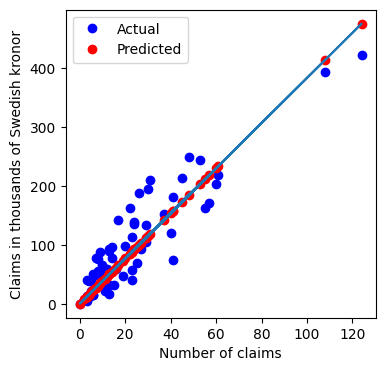

In [10]:
fig, ax = plot_results(
    features,
    labels,
    forward_pass(features, weight, bias)
)

That looks pretty good! Now we can use our model to make some predictions

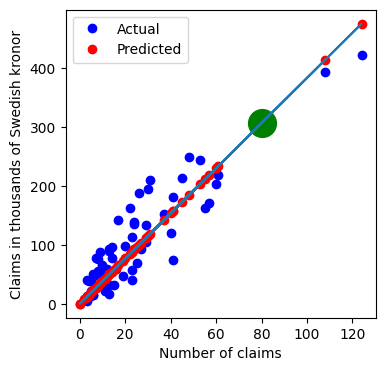

In [11]:
new_number_of_claims = jnp.array([80])
prediction = forward_pass(new_number_of_claims, weight, bias)
ax.scatter(new_number_of_claims, prediction, s=400, c='g')

fig

Pretty cool. We build a model, got a better understanding of a loss/cost function (remember what the difference is?), implemented gradient descent and finally made a prediction. If you made it this far, I congratulate you! 

## Lets build a slightly more complex model leveraging JAX

In [12]:
from jax import random
from jax import grad, jit, vmap
from typing import Tuple
import jax.numpy as jnp

keygen = random.PRNGKey(0)

def init_weights(features_in: int, features_out: int, key: random.PRNGKey) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return random.normal(key, shape=(features_in, features_out)), random.normal(key, shape=(features_out,))

def relu(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.maximum(x, 0)

def forward(params, x):
    activations = x
    # for all layers except the last one (as we that won't have a relu activation)
    for weights, bias in params[:-1]:
        activations = relu(jnp.dot(jnp.transpose(weights), activations) + bias)

    output_layer_weights, output_layer_bias = params[-1]
    predictions = jnp.dot(jnp.transpose(output_layer_weights), activations) + output_layer_bias
    return predictions

batched_forward = vmap(forward, in_axes=(None, 0))

def loss(predictions, labels):
    return (predictions - labels) ** 2

def cost(params, x, y):
    predictions = batched_forward(params, x)
    return jnp.sum(loss(predictions, y)) / predictions.shape[0]

def cost_which_wont_work(predictions, y):
    return jnp.mean(loss(predictions, y))

@jit
def update(params, x, y, alpha):
    grads = grad(cost)(params, x, y)

    return [
        (w - alpha * dw, b - alpha * db) for (w, b), (dw, db) in zip(params, grads)
    ]


n_features_per_sample = 1

layers = [n_features_per_sample, 10, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]

# params = random.normal(random.PRNGKey(1), (784, 15))
random_image = random.normal(random.PRNGKey(1), (n_features_per_sample,))
sample = forward(params, random_image)
print(f"shape of sample: {sample.shape}")

random_images_batch = random.normal(random.PRNGKey(1), (20, n_features_per_sample))
try:
    batch = forward(params, random_images_batch)
    print(f"batch shape is: {batch.shape}")
except TypeError: 
    print(f"Incompatible shapes for dot: got (15, n_features_per_sample) and (20, n_features_per_sample).")

batched_forward = vmap(forward, in_axes=(None, 0))
batch = batched_forward(params, random_images_batch)
print(f"shape of batch: {batch.shape}")


# batch = forward(r)
# batch = batched_forward(random_images_batch, params)
# print(f"sample shape is: {sample.shape}, batch shape is: {batch.shape}")


# w_out, w_in = 20, 1
#w_out, w_in = 512, 784

shape of sample: (1,)
Incompatible shapes for dot: got (15, n_features_per_sample) and (20, n_features_per_sample).
shape of batch: (20, 1)


In [13]:
print(f"shape of grads: {x.shape}")
print(f"shape of grads: {y.shape}")
for w, b in params:
    print(f"shape of w: {w.shape}, shape of b: {b.shape}")


shape of grads: (50,)
shape of grads: (50,)
shape of w: (1, 10), shape of b: (10,)
shape of w: (10, 1), shape of b: (1,)


In [14]:
x = random.normal(random.PRNGKey(1), (20, n_features_per_sample))
y = random.normal(random.PRNGKey(1), (20, 1))
predictions = batched_forward(params, x)
cost_batch = cost(params, x, y)
grads = grad(cost)(params, x, y)
# grads

Epoch: 0 Cost: 3424.99462890625
Epoch: 5 Cost: 1420.6473388671875
Epoch: 10 Cost: 1417.3609619140625
Epoch: 15 Cost: 1416.433349609375
Epoch: 20 Cost: 1415.5302734375
Epoch: 25 Cost: 1414.6259765625
Epoch: 30 Cost: 1413.7198486328125
Epoch: 35 Cost: 1412.81201171875
Epoch: 40 Cost: 1411.9024658203125
Epoch: 45 Cost: 1410.990966796875


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:xlabel='Number of claims', ylabel='Claims in thousands of Swedish kronor'>)

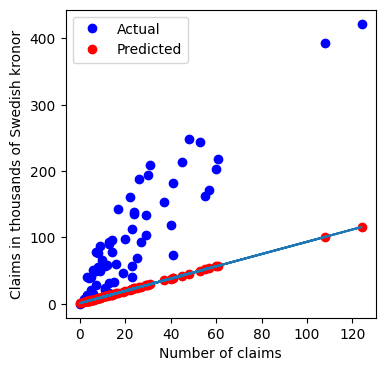

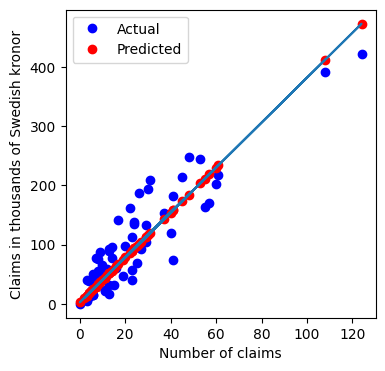

In [15]:
# layers_init
n_epochs = 50

layers = [n_features_per_sample, 10, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]
costs = []
y_pred = batched_forward(params, features)
plot_results(features, labels, y_pred)
for epoch in range(n_epochs):
    params = update(params, features, labels, learning_rate)
    if epoch % 5 == 0:
        batch_cost = cost(params, features, labels)
        print(f"Epoch: {epoch} Cost: {batch_cost}")
        costs.append(batch_cost)


y_pred = batched_forward(params, features)
plot_results(features, labels, y_pred)

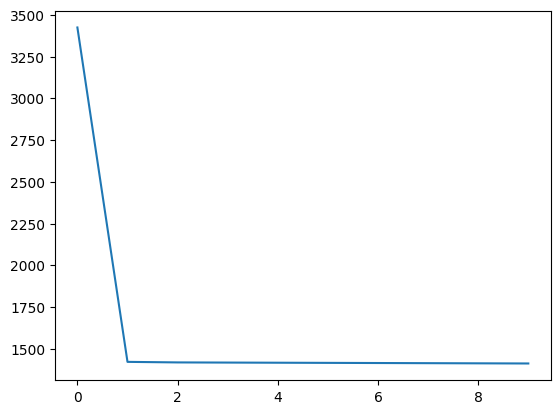

In [16]:
plt.plot(costs)

In [130]:
from jax import random
from jax import grad, jit, vmap
from typing import Tuple
import jax.numpy as jnp
import matplotlib.pyplot as plt

keygen = random.PRNGKey(0)

def init_weights(features_in: int, features_out: int, key: random.PRNGKey, scale=1e-2) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return scale * random.normal(key, shape=(features_in, features_out)), scale * random.normal(key, shape=(features_out,))

def relu(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.maximum(x, 0)

def forward(params, x):
    activations = x
    # for all layers except the last one (as we that won't have a relu activation)
    for weights, bias in params[:-1]:
        activations = relu(jnp.dot(jnp.transpose(weights), activations) + bias)

    output_layer_weights, output_layer_bias = params[-1]
    predictions = jnp.dot(jnp.transpose(output_layer_weights), activations) + output_layer_bias
    return predictions


n_features_per_sample = 1
layers = [n_features_per_sample, 32, 32, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]
sample = jnp.array([5])
forward(params, sample)
batch = jnp.array([[5], [5]])
batch.shape
vforward = vmap(forward, in_axes=(None, 0))
pred = vforward(params, batch)
labels = jnp.array([10, 10])

def mse_cost(params, x, y):
    predictions = vforward(params, x)
    squared_error = (predictions - y) ** 2
    mse = jnp.mean(squared_error)
    return mse

assert (pred - jnp.reshape(labels, (labels.shape[0], 1))).shape == (2,1)
pred - labels


DeviceArray([[-10.001262, -10.001262],
             [-10.001262, -10.001262]], dtype=float32)

In [147]:

@jit
def update_params(params, x, y, alpha):
    grads = grad(mse_cost)(params, x, y)
    return [
        (w - alpha * dw, b - alpha * db) for (w, b), (dw, db) in zip(params, grads)
    ]

n_samples = 1000
noise = random.normal(random.PRNGKey(1), (n_samples, ))
x = jnp.linspace(-10, 10, num=1000)
y = 0.1*x*jnp.cos(x) + 0.1*random.normal(random.PRNGKey(1), (1000,))
# plt.scatter(x, y)
x = jnp.reshape(x, (x.shape[0], n_features_per_sample))

y = jnp.reshape(y, (y.shape[0], 1))
layers = [n_features_per_sample, 128, 128, 128, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]
learning_rate = 0.01



In [150]:

n_epochs = 200000
for epoch in range(n_epochs):
    params = update_params(params, x, y, learning_rate)
    if epoch % 1000 == 0:
        batch_cost = cost(params, x, y)
        print(f"Epoch: {epoch} Cost: {batch_cost}")
        costs.append(batch_cost)

Epoch: 0 Cost: 0.015088026411831379
Epoch: 1000 Cost: 0.014280706644058228
Epoch: 2000 Cost: 0.013823368586599827
Epoch: 3000 Cost: 0.01350277941673994
Epoch: 4000 Cost: 0.013245701789855957
Epoch: 5000 Cost: 0.013014142401516438
Epoch: 6000 Cost: 0.012861030176281929
Epoch: 7000 Cost: 0.0127625223249197
Epoch: 8000 Cost: 0.012675592675805092
Epoch: 9000 Cost: 0.012599791400134563
Epoch: 10000 Cost: 0.01252053678035736
Epoch: 11000 Cost: 0.012433058582246304
Epoch: 12000 Cost: 0.01234935037791729
Epoch: 13000 Cost: 0.012272707186639309
Epoch: 14000 Cost: 0.012209452688694
Epoch: 15000 Cost: 0.012158991768956184
Epoch: 16000 Cost: 0.012122120708227158
Epoch: 17000 Cost: 0.0120845977216959
Epoch: 18000 Cost: 0.012061439454555511
Epoch: 19000 Cost: 0.01204423513263464
Epoch: 20000 Cost: 0.01203257404267788
Epoch: 21000 Cost: 0.012022526003420353
Epoch: 22000 Cost: 0.01201313640922308
Epoch: 23000 Cost: 0.012003794312477112
Epoch: 24000 Cost: 0.011994082480669022
Epoch: 25000 Cost: 0.01198

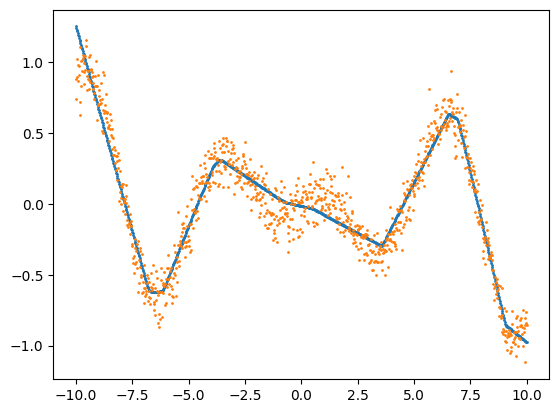

In [149]:

pred = vforward(params, x)
plt.scatter(x, pred, s=1, )
plt.scatter(x, y, s=1)

## Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()
